In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Importing Necessary Libararies**

In [2]:
import os
import shutil
import numpy as np
from glob import glob
import logging
from PIL import Image
import matplotlib.pyplot as plt
import skimage.segmentation as segmentation
import h5py
import cv2
import tarfile

In [3]:
def makdir(dir):
  if not os.path.exists(dir):
    # print(dir)
    os.makedirs(dir)
dsDir = '/content/Dataset'

concept_dir = dsDir + '/concepts'
concept_dir_cache = dsDir + '/concepts_embeddings'
# makdir(dsDir)
makdir(concept_dir)
makdir(concept_dir_cache)

base_dir_imgs = dsDir + '/orginal_images'
base_dir_imgs_cache = dsDir + '/orginal_images_cache'
makdir(base_dir_imgs)
makdir(base_dir_imgs_cache)

In [ ]:
# os.makedirs('/content/Dataset/concepts')

# **A. If Data is not Processed**

## **Data Preparation**

### **Copying and extracting Orginal Images and Concepts into CoLab Space**

In [ ]:

def makdir(dir):
  if not os.path.exists(dir):
    os.mkdir(dir)

!cp '/content/drive/MyDrive/Colab Notebooks/Clustering/K-Means/selective_15classes_cub.zip' '/content/'
!unzip '/content/selective_15classes_cub.zip' -d '/content/Dataset/'
os.remove('/content/selective_15classes_cub.zip')


Archive:  /content/selective_15classes_cub.zip
   creating: /content/Dataset/orginal_images/001.Black_footed_Albatross/
  inflating: /content/Dataset/orginal_images/001.Black_footed_Albatross/Black_Footed_Albatross_0001_796111.jpg  
  inflating: /content/Dataset/orginal_images/001.Black_footed_Albatross/Black_Footed_Albatross_0002_55.jpg  
  inflating: /content/Dataset/orginal_images/001.Black_footed_Albatross/Black_Footed_Albatross_0003_796136.jpg  
  inflating: /content/Dataset/orginal_images/001.Black_footed_Albatross/Black_Footed_Albatross_0005_796090.jpg  
  inflating: /content/Dataset/orginal_images/001.Black_footed_Albatross/Black_Footed_Albatross_0006_796065.jpg  
  inflating: /content/Dataset/orginal_images/001.Black_footed_Albatross/Black_Footed_Albatross_0007_796138.jpg  
  inflating: /content/Dataset/orginal_images/001.Black_footed_Albatross/Black_Footed_Albatross_0008_796083.jpg  
  inflating: /content/Dataset/orginal_images/001.Black_footed_Albatross/Black_Footed_Albatros

In [ ]:
# !tar -xvf  '/content/drive/MyDrive/Datasets/CUB_200_2011.tgz' -C '/content'

### **Renaming Directories**

In [ ]:
# # named_selected_classes = ['004.Groove_billed_Ani', '005.Crested_Auklet', '012.Yellow_headed_Blackbird', '014.Indigo_Bunting', '016.Painted_Bunting', '017.Cardinal', '034.Gray_crowned_Rosy_Finch', '038.Great_Crested_Flycatcher', '045.Northern_Fulmar', '047.American_Goldfinch']

# base_dir_imgs = '/content/filtered_concepts/'

classes_names = sorted(os.listdir(base_dir_imgs))
# print(classes_names)
for new_name, old_name in enumerate(classes_names):
  os.rename(os.path.join(concept_dir, str(old_name)), os.path.join(concept_dir, str(new_name)))
  os.rename(os.path.join(base_dir_imgs, str(old_name)), os.path.join(base_dir_imgs, str(new_name)))
  print('Class {} is renamed to class {}'.format(old_name, new_name))

Class 001.Black_footed_Albatross is renamed to class 0
Class 009.Brewer_Blackbird is renamed to class 1
Class 016.Painted_Bunting is renamed to class 2
Class 021.Eastern_Towhee is renamed to class 3
Class 036.Northern_Flicker is renamed to class 4
Class 042.Vermilion_Flycatcher is renamed to class 5
Class 044.Frigatebird is renamed to class 6
Class 048.European_Goldfinch is renamed to class 7
Class 057.Rose_breasted_Grosbeak is renamed to class 8
Class 058.Pigeon_Guillemot is renamed to class 9
Class 062.Herring_Gull is renamed to class 10
Class 069.Rufous_Hummingbird is renamed to class 11
Class 075.Green_Jay is renamed to class 12
Class 083.White_breasted_Kingfisher is renamed to class 13
Class 100.Brown_Pelican is renamed to class 14


### **ResNet50 model implementation for Feature Extraction**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class ResNet(nn.Module):
    def __init__(self, config, output_dim):
        super().__init__()

        block, n_blocks, channels = config
        self.in_channels = channels[0]

        assert len(n_blocks) == len(channels) == 4

        self.conv1 = nn.Conv2d(3, self.in_channels, kernel_size = 7, stride = 2, padding = 3, bias = False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace = True)
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)

        self.layer1 = self.get_resnet_layer(block, n_blocks[0], channels[0])
        self.layer2 = self.get_resnet_layer(block, n_blocks[1], channels[1], stride = 2)
        self.layer3 = self.get_resnet_layer(block, n_blocks[2], channels[2], stride = 2)
        self.layer4 = self.get_resnet_layer(block, n_blocks[3], channels[3], stride = 2)

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, output_dim)

    def get_resnet_layer(self, block, n_blocks, channels, stride = 1):

        layers = []

        if self.in_channels != block.expansion * channels:
            downsample = True
        else:
            downsample = False

        layers.append(block(self.in_channels, channels, stride, downsample))

        for i in range(1, n_blocks):
            layers.append(block(block.expansion * channels, channels))

        self.in_channels = block.expansion * channels

        return nn.Sequential(*layers)

    def forward(self, x):

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.fc(h)

        return x, h

In [ ]:
class Bottleneck(nn.Module):

    expansion = 4

    def __init__(self, in_channels, out_channels, stride = 1, downsample = False):
        super().__init__()

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size = 3,
                               stride = stride, padding = 1, bias = False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, self.expansion * out_channels, kernel_size = 1,
                               stride = 1, bias = False)
        self.bn3 = nn.BatchNorm2d(self.expansion * out_channels)

        self.relu = nn.ReLU(inplace = True)

        if downsample:
            conv = nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size = 1,
                             stride = stride, bias = False)
            bn = nn.BatchNorm2d(self.expansion * out_channels)
            downsample = nn.Sequential(conv, bn)
        else:
            downsample = None

        self.downsample = downsample

    def forward(self, x):

        i = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)

        if self.downsample is not None:
            i = self.downsample(i)

        x += i
        x = self.relu(x)

        return x

In [ ]:
print(device)

cuda


In [ ]:
pretrained_model = models.resnet50(pretrained = True)
IN_FEATURES = pretrained_model.fc.in_features
OUTPUT_DIM = 200
fc = nn.Linear(IN_FEATURES, OUTPUT_DIM)
pretrained_model.fc = fc
ResNetConfig = namedtuple('ResNetConfig', ['block', 'n_blocks', 'channels'])
resnet50_config = ResNetConfig(block = Bottleneck,
                               n_blocks = [3, 4, 6, 3],
                               channels = [64, 128, 256, 512])
model = ResNet(resnet50_config, OUTPUT_DIM)

modelPath = '/content/drive/MyDrive/Colab Notebooks/Clustering/K-Means/cub_resnet_model.pt'
# modelPath = '/content/drive/MyDrive/Colab Notebooks/Clustering/K-Means/ResNet_best_model.pth'

# model.load_state_dict(copy.deepcopy(torch.load(modelPath, map_location=torch.device('cpu'))))
model.load_state_dict(torch.load(modelPath, map_location = device))

model.eval()
model = model.to(device)

In [ ]:
# input_image = '/content/Black_Footed_Albatross_0001_796111.jpg'
# input_image = '/content/Black_Footed_Albatross_0080_796096.jpg'
input_image = '/content/Dataset/orginal_images/10/Herring_Gull_0001_48205.jpg'
input_var = plt.imread(input_image)
# print(np.max(input_var))
input_var = input_var/255
print(input_var.shape)
# # input_var = torch(input_var.permute(1, 2, 0))
input_var = np.swapaxes(input_var,0,2)
input_var = np.swapaxes(input_var,1,2)

input_var = np.expand_dims(input_var, axis=0)
# print(input_var.shape)

img =torch.tensor(input_var, device=device).float()

# x = torch.randn(1, 3, 224, 224).to(device)
output, _ = model(img)
# print(output)
# print(output)
pred = output.cpu().detach().numpy()
print(np.argmax(pred, axis=1))

(286, 500, 3)


ValueError: ignored

In [ ]:
img = plt.imread('/content/Dataset/orginal_images/0/Black_Footed_Albatross_0001_796111.jpg')
print(img.shape)

(223, 320, 3)


**Feature Extraction**

In [ ]:
modules=list(model.children())[:-1]
model=nn.Sequential(*modules)
features_var=model(img)
features = features_var.cpu().detach().numpy()
features = features.squeeze()
print(features.shape)

NameError: ignored

In [ ]:
input_dir = '/content/CUB_200_2011/images/041.Scissor_tailed_Flycatcher'

# input_dir = '/content/Dataset/orginal_images/075.Green_Jay'


files = os.listdir(input_dir)

for input_img in files:
  filePath = os.path.join(input_dir,input_img)
  # input_image = '/content/Black_Footed_Albatross_0005_796090.jpg'
  input_var = plt.imread(filePath)
  # print(np.max(input_var))
  input_var = input_var/255
  # print(input_var.shape)
  # # input_var = torch(input_var.permute(1, 2, 0))
  input_var = np.swapaxes(input_var,0,2)
  input_var = np.swapaxes(input_var,1,2)
  input_var = np.expand_dims(input_var, axis=0)
  # print(input_var.shape)
  img =torch.tensor(input_var, device=device).float()
  # x = torch.randn(1, 3, 224, 224).to(device)
  output, _ = model(img)
  # print(output)
  # print(output)
  pred = output.cpu().detach().numpy()
  print(np.argmax(pred, axis=1))

[2]


### **VGG16 model implementation for Feature Extraction**

In [ ]:
import numpy as np
from numpy import linalg as LA
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications import ResNet50
from keras.preprocessing import image
from keras.models import Model


class VGGNet:
    def __init__(self):
        # weights: 'imagenet'
        # pooling: 'max' or 'avg'
        # input_shape: (width, height, 3), width and height should >= 48
        self.input_shape = (224, 224, 3)
        self.weight = 'imagenet'
        self.pooling = 'max'
        self.model = VGG16(weights = self.weight, input_shape = (self.input_shape[0], self.input_shape[1], self.input_shape[2]), pooling = self.pooling, include_top = False)
        self.model.predict(np.zeros((1, 224, 224 , 3)))

    '''
    Use vgg16 model to extract features
    Output normalized feature vector
    '''
    def extract_feat(self, img_path):
        img = image.load_img(img_path, target_size=(self.input_shape[0], self.input_shape[1]))
        img = image.img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        feat = self.model.predict(img)
        norm_feat = feat[0]/LA.norm(feat[0])
        return norm_feat
## defining Model for feature extraction

feature_extractor = 'VGG'
model = VGGNet()

# if feature_extractor == 'VGG':
#   model = VGGNet()
# elif feature_extractor == 'ResNet50':
#   resnet = ResNet50(weights="imagenet", include_top=True)
#   model = Model(resnet.inputs, resnet.layers[-3].output)
print('Model has been downloaded and ready to use')

58900480/58889256 [==============================] - 2s 0us/step
Model has been downloaded and ready to use


In [ ]:
# from tensorflow.keras.applications.resnet50 import preprocess_input
# img = cv2.imread('/content/Dataset/filtered_concepts/0/10_332.png')
# img = cv2.resize(img,(224,224))

# img_dim = np.expand_dims(img, axis=0)
# print(img_dim.shape)

# # model.summary()
# features = model.predict(img_dim)
# features = features.reshape((features.shape[0], 7 * 7 * 2048))

(1, 224, 224, 3)


### **Embedding Method Defination**

In [ ]:
def _extract_patch(image, mask):
  mask_expanded = np.expand_dims(mask, -1)
  patch = (mask_expanded * image + (1 - mask_expanded) * float(117) / 255)
  ones = np.where(mask == 1)
  h1, h2, w1, w2 = ones[0].min(), ones[0].max(), ones[1].min(), ones[1].max()
  image = Image.fromarray((patch[h1:h2, w1:w2] * 255).astype(np.uint8))
  image_resized = np.array(image.resize((256,256),Image.BICUBIC)).astype(float) / 255
  return image_resized, patch

def calculate_Embeddings(orig_imgs_dir, imgs_dir_cache, isConcept):
  class_lst = [x for x in sorted(os.listdir(orig_imgs_dir)) if not x.startswith('.')]
  target_size = (256, 256)

  for cls in class_lst:
    if not os.path.exists(os.path.join(imgs_dir_cache, cls)):
      os.mkdir(os.path.join(imgs_dir_cache, cls))
    imgs_path = [(os.path.splitext(x)[0]) for x in sorted(os.listdir(os.path.join(orig_imgs_dir, cls))) if not x.startswith('.')]

    print('\n\nClass:', str(cls))
    for pth_ind in range(len(imgs_path)):
      if isConcept:
        norm_feat = []
        features = model.extract_feat(glob(os.path.join(orig_imgs_dir, cls, imgs_path[pth_ind]+'*'))[0])
        norm_feat.append(features)
        with h5py.File(os.path.join(imgs_dir_cache, cls, imgs_path[pth_ind]+'.hdf5'), 'w') as f:
          f.create_dataset('norm_feat', data = np.asarray(norm_feat))
      else:
        img = np.asarray(Image.open(glob(os.path.join(orig_imgs_dir, cls, imgs_path[pth_ind]+'*'))[0]).convert('RGB').resize(target_size))
        img_class = cls
        # segments = segmentation.slic(img, n_segments=7, compactness=20*3, sigma=1.*3)

        ##### parameters same as in concept extraction
        segments = segmentation.slic(img, n_segments=10, compactness=20*3, sigma=1.*3)

        superpixels, norm_feat = [], []
        # superpixels, imgs_names, norm_feat, sp_label = [], [], [], []
        for s in range(segments.max()):
          mask = (segments == s).astype(float)
          superpixel, patch = _extract_patch(img/255, mask)
          superpixels.append(superpixel)
          # imgs_names.append(imgs_path[pth_ind])
          plt.imsave('/content/temp.jpg', superpixel)
          features = model.extract_feat('/content/temp.jpg')
          norm_feat.append(features)
          os.remove('/content/temp.jpg')
          # sp_label.append(img_class)
        with h5py.File(os.path.join(imgs_dir_cache, cls, imgs_path[pth_ind]+'.hdf5'), 'w') as f:
          f.create_dataset('superpixels', data = np.asarray(superpixels))
          f.create_dataset('norm_feat', data = np.asarray(norm_feat))
      print('\rCalculating superpixels and Embeddings', pth_ind+1, end='')

### **Building Caches for concepts and memories**

In [ ]:
print('@'*20 + ' Embedding creation for Orginal Image is starting ' + '@'*20)
calculate_Embeddings(base_dir_imgs, base_dir_imgs_cache, isConcept=False)
print('\n='*20 + ' Embeddings creation ended ' + '='*20)
print('-'*50)

print('@'*20 + ' Embedding creation for Concepts is starting ' + '@'*20)
calculate_Embeddings(concept_dir, concept_dir_cache, isConcept=True)
print('='*20 + ' Embeddings creation ended ' + '='*20)
print('-'*50)

@@@@@@@@@@@@@@@@@@@@ Embedding creation for Orginal Image is starting @@@@@@@@@@@@@@@@@@@@


Class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.


Calculating superpixels and Embeddings 60

Class: 1
Calculating superpixels and Embeddings 58

Class: 10
Calculating superpixels and Embeddings 60

Class: 11
Calculating superpixels and Embeddings 60

Class: 12
Calculating superpixels and Embeddings 57

Class: 13
Calculating superpixels and Embeddings 60

Class: 14
Calculating superpixels and Embeddings 60

Class: 2
Calculating superpixels and Embeddings 58

Class: 3
Calculating superpixels and Embeddings 60

Class: 4
Calculating superpixels and Embeddings 60

Class: 5
Calculating superpixels and Embeddings 60

Class: 6
Calculating superpixels and Embeddings 60

Class: 7
Calculating superpixels and Embeddings 60

Class: 8
Calculating superpixels and Embeddings 60

Class: 9
Calculating superpixels and Embeddings 58
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
=
= Embeddings creation ended ====================
--------------------------------------------------
@@@@@@@@@@@@@@@@@@@@ Embedding creation for Concepts is starting @@@@@@@@@@@@@@@@@@@@



### **Saving Complete Dataset along with caches onto Google Drive**

In [ ]:
import tarfile
def make_tarfile(output_filename, source_dir):
    with tarfile.open(output_filename, "w:gz") as tar:
        tar.add(source_dir, arcname=os.path.basename(source_dir))

# make_tarfile('softNetDataSet.tar', dsDir)
# !cp '/content/softNetDataSet.tar' '/content/drive/MyDrive/Colab Notebooks/ACE/Data'

make_tarfile('15_classes_embeddings_02_03_2022.tar', dsDir)
!cp '/content/15_classes_embeddings_02_03_2022.tar' '/content/drive/MyDrive/Colab Notebooks/Clustering/K-Means'

# **If Data is Processed Already**

In [3]:
!cp  '/content/drive/MyDrive/Colab Notebooks/Clustering/K-Means/15_classes_embeddings_09_03_2022.tar' '/content'
!tar --extract --file '/content/15_classes_embeddings_09_03_2022.tar'

In [4]:
dsDir = '/content/Dataset'

concept_dir = dsDir + '/concepts'
concept_dir_cache = dsDir + '/concepts_embeddings'

base_dir_imgs = dsDir + '/orginal_images'
base_dir_imgs_cache = dsDir + '/orginal_images_cache'


# **Clustering the Embeddings using K-Mean clustering**

In [ ]:
# %cd /content/drive/MyDrive/Colab Notebooks/Clustering/K-Means

In [ ]:
# print(os.listdir(concept_dir_cache))

In [ ]:
# #Nauman
# concept_dir = '/content/drive/MyDrive/0_softnet_v2/0/cub_19_ext/concept/filtered_output_concepts'
# concept_dir_cache = '/content/drive/MyDrive/0_softnet_v2/0/cub_19_ext/concept/filtered_output_concepts_cache'

## **Reading Embeddings**

In [5]:
concept_embeddings_name = []
concept_embeddings = []
concept_image_name = []
concept_label = []

dataList = []

# record = 0

dirs = sorted(os.listdir(concept_dir_cache))
print(dirs)
for subDir in dirs:
  subDirPath = os.path.join(concept_dir_cache,subDir)
  files = sorted(os.listdir(subDirPath))
  for file in files:
    filename, file_extension = os.path.splitext(file)

    filePath = os.path.join(subDirPath,file)
    concept_embeddings_name.append(filePath)
    concept_label.append(subDir)
    concept_image = os.path.join(concept_dir,subDir,filename+'.png')
    concept_image_name.append(concept_image)

    # print(filePath)
    with h5py.File(filePath, 'r') as f:
      norm_feat = f['norm_feat'][()]   #key changed from embedding to norm_feat
      norm_feat = np.squeeze(norm_feat)
      concept_embeddings.append(norm_feat)
    mytuple = (concept_embeddings_name,concept_image_name,concept_label)
    # record += 1
    # print(record)
    dataList.append(mytuple)

concept_embeddings_name = np.array(concept_embeddings_name)
concept_embeddings = np.array(concept_embeddings)
concept_image_name = np.array(concept_image_name)
concept_label = np.array(concept_label)

['0', '1', '10', '11', '12', '13', '14', '2', '3', '4', '5', '6', '7', '8', '9']


## **Saving Data into Dataframe for further use**

In [7]:
# # print(dataList[0][0][0])
# # # print(dataList[0][2][0])
# # print(dataList[0][2][0])
# # print(dataList[0][3][0])

# import pandas as pd
# df = pd.DataFrame(dataList)
# savePath = '/content/drive/MyDrive/Colab Notebooks/Clustering/K-Means/'
# df.to_csv(savePath  + 'clustering_Data_08_07_2023.csv')

In [8]:
# def fileCounter(folder):
#   count = 0
#   dirs = os.listdir(folder)
#   for subDir in dirs:
#     subDirPath = os.path.join(folder,subDir)
#     files = os.listdir(subDirPath)
#     for file in files:
#       filePath = os.path.join(subDirPath,file)
#       if os.path.isfile(filePath):
#         count += 1
#   return count

In [ ]:
# print(fileCounter('/content/Dataset/concepts_embeddings'))

In [9]:

# # concept_embeddings_array = np.squeeze(np.array(dataframe.iloc[:,2]))
# concept_embeddings_array = np.squeeze(np.array(concept_embeddings))
# print(concept_embeddings.shape)

(1171, 512)


In [ ]:
# for embedding in concept_embeddings_array:
#   print(embedding)

### **Clustering using K-Means**

In [6]:
import sklearn.cluster as cluster

n_clusters = 150
print('\nStart KM-Clustring')
km = cluster.KMeans(n_clusters, verbose=True, copy_x=False, algorithm="full")
d = km.fit_predict(np.array(concept_embeddings))
print('End Fitting')
centers = km.cluster_centers_
print('End Centering')


Start KM-Clustring


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


Initialization complete
Iteration 0, inertia 550.2054443359375.
Iteration 1, inertia 331.61767578125.
Iteration 2, inertia 329.9241943359375.
Iteration 3, inertia 329.5635681152344.
Iteration 4, inertia 329.44525146484375.
Iteration 5, inertia 329.3691101074219.
Converged at iteration 5: strict convergence.
Initialization complete
Iteration 0, inertia 550.00634765625.
Iteration 1, inertia 330.96112060546875.
Iteration 2, inertia 329.66815185546875.
Iteration 3, inertia 329.50823974609375.
Converged at iteration 3: strict convergence.
Initialization complete
Iteration 0, inertia 550.9461669921875.
Iteration 1, inertia 331.5245056152344.
Iteration 2, inertia 330.2126159667969.
Iteration 3, inertia 329.9134521484375.
Iteration 4, inertia 329.83905029296875.
Converged at iteration 4: strict convergence.
Initialization complete
Iteration 0, inertia 551.4110107421875.
Iteration 1, inertia 331.70672607421875.
Iteration 2, inertia 330.2889709472656.
Iteration 3, inertia 330.04351806640625.
Ite

## **Save Clustering Model**

In [7]:
# save the model
import pickle

%cd '/content/drive/MyDrive/Colab Notebooks/Clustering/K-Means'
pickle.dump(km, open("kmeans_15_classes_150_clusters_VGG_08_07_2023.pkl", "wb"))

# load the model
# kmean_loaded = pickle.load(open("kmeans_19_classes_190_clusters_ResNet50.pkl", "rb"))

/content/drive/MyDrive/Colab Notebooks/Clustering/K-Means


In [ ]:
# print(kmean_loaded)

KMeans(algorithm='full', copy_x=False, n_clusters=190, verbose=True)


## **Load Previosuly Saved Model**

In [ ]:
#Nauman
# save the model
import pickle

# load the model
path = '/content/drive/MyDrive/Colab Notebooks/Clustering/K-Means/kmeans_15_classes_150_clusters_VGG_8_7_2023.pkl'

# path = '/content/drive/MyDrive/0_softnet_v2/Kmean/ahsan/K-Means/kmeans_15_classes_150_clusters_VGG.pkl'

# path = '/content/drive/MyDrive/0_softnet_v2/Kmean/ahsan/K-Means/kmeans_19_classes.pkl'

km = pickle.load(open(path, "rb"))

getting concepts near centroids

In [ ]:
# kmean_loaded = km

centers = km.cluster_centers_
print(len(centers))

# from scipy.spatial.distance import cdist
# distance = cdist(concept_embeddings_array, centers)

150


In [ ]:
print(centers.shape)

(150, 512)


In [ ]:
# import numpy as np
# concept_embeddings_array = np.zeros((8,512))
# print(concept_embeddings_array.shape)

In [ ]:
# predicted_labels = km.predict(concept_embeddings)
# print(predicted_labels[0:30])

[147 129  68  76 110 124  30 116 125  86  51 125  13  51 117  21  90   3
 130  70  45  84  35 101 147  71 103 116 128 124]


## **Pupulating Concepts over Cluster centers**

In [8]:
from scipy.spatial.distance import cdist
distance = cdist(concept_embeddings, centers)
print(distance.shape)

(1171, 150)


In [9]:
def makdir(dir):
  if not os.path.exists(dir):
    # print(dir)
    os.makedirs(dir)

In [10]:
import array
from PIL import Image
predicted_labels = km.predict(concept_embeddings)

print(type(predicted_labels))
save_dir = '/content/drive/MyDrive/Colab Notebooks/Clustering/K-Means/concepts_clusterwise_08_07_2023'
makdir(save_dir)

centers = km.cluster_centers_
per_cluster_concepts=[]

for cluster_id in range(len(centers)):
  concepts_indexs = np.where(predicted_labels == cluster_id)
  # print(len(concepts_indexs[0]))
  # pred_concept_names = concept_image_name[concepts_indexs]
  # print(concepts_indexs)
  print('Images in Cluster # {}'.format(cluster_id))
  cluster_dir = os.path.join(save_dir,str(cluster_id))
  makdir(cluster_dir)

  for _index in concepts_indexs[0]:
    # print(len(concepts_indexs))
    source_FilePath = concept_image_name[_index]
    filename = os.path.basename(source_FilePath)
    print('cluster id {0}  , class label {1},  concept name {2}'.format(cluster_id, concept_label[_index],filename))
    myTuple = (cluster_id, concept_label[_index],filename)
    per_cluster_concepts.append(myTuple)
    destfilePathComplete = os.path.join(cluster_dir,filename)
  # print(pred_concept_name)
    # print(destfilePathComplete)
    # file = Image.open(source_FilePath)
    # plt.imshow(file)
    # plt.show()
    shutil.copyfile(source_FilePath, destfilePathComplete)

<class 'numpy.ndarray'>
Images in Cluster # 0
cluster id 0  , class label 10,  concept name 32_45.png
cluster id 0  , class label 14,  concept name 23_441.png
cluster id 0  , class label 7,  concept name 11_220.png
cluster id 0  , class label 7,  concept name 19_133.png
cluster id 0  , class label 7,  concept name 23_341.png
cluster id 0  , class label 7,  concept name 5_235.png
Images in Cluster # 1
cluster id 1  , class label 0,  concept name 10_67.png
cluster id 1  , class label 0,  concept name 38_392.png
cluster id 1  , class label 1,  concept name 21_395.png
cluster id 1  , class label 1,  concept name 32_173.png
cluster id 1  , class label 1,  concept name 40_13.png
cluster id 1  , class label 14,  concept name 11_473.png
cluster id 1  , class label 14,  concept name 15_185.png
cluster id 1  , class label 2,  concept name 27_76.png
cluster id 1  , class label 7,  concept name 16_357.png
Images in Cluster # 2
cluster id 2  , class label 12,  concept name 17_257.png
cluster id 2  

In [11]:
import pandas as pd
dfClusterWise = pd.DataFrame(per_cluster_concepts)
savePath = '/content/drive/MyDrive/Colab Notebooks/Clustering/K-Means/'
dfClusterWise.to_csv(savePath  + 'clusterWise_concept_Details_08_07_2023.csv')

## **for single centroid only**

In [ ]:
# print(concept_embeddings_name[0])
# # print(concept_embeddings[0])
# print(concept_image_name[0])
# print(concept_label[0])

In [ ]:
import matplotlib.pyplot as plt
pred_center = np.argmin(distance[:,0])
pred_concept_name = concept_embeddings_name [pred_center]
print('center : {}  , concept name {}'.format(pred_center,pred_concept_name))
img = plt.imread(concept_image_name[pred_center])
plt.imshow(img)
plt.show()

NameError: ignored

In [ ]:
distance.shape[1]

200

## **Saving Cluster Centers of each class**

In [12]:
# concept_embeddings_name = []
# concept_embeddings = []
# concept_image_name = []
# concept_label = []

import matplotlib.pyplot as plt
import shutil

concepts_names_clusterwise = []
concept_embeddings_clusterwise = []


save_dir = '/content/drive/MyDrive/Colab Notebooks/Clustering/K-Means/Classwise_15_Concepts_150_VGG_08_07_2023'
makdir(save_dir)

for concep_ind in range(distance.shape[1]):
  # print(distance[:concep_ind])
  print(concep_ind)
  pred_center = np.argmin(distance[:,concep_ind])
  pred_concept_name = concept_image_name[pred_center]
  concepts_names_clusterwise.append(pred_concept_name)

  pred_concept_embeddings = concept_embeddings[pred_center]
  concept_embeddings_clusterwise.append(pred_concept_embeddings)

  dirname = os.path.basename(os.path.dirname(pred_concept_name))
  # complete_dirPath = os.path.join(save_dir,dirname)
  filename = os.path.basename(pred_concept_name)
  extension = os.path.splitext(filename)[1]
  # print(extension)
  print('center index : {}  , concept name {}'.format(pred_center,pred_concept_name))
  # img = plt.imread(pred_concept_name)

  filePathComplete = os.path.join(save_dir,str(concep_ind) + extension)

  makdir(save_dir + '/' + dirname)
  filePathComplete2 = os.path.join(save_dir,dirname,str(concep_ind) + extension)

  print(pred_concept_name)
  print(filePathComplete)
  shutil.copyfile(pred_concept_name, filePathComplete)
  shutil.copyfile(pred_concept_name, filePathComplete2)

import pandas as pd
cluster_pd = pd.DataFrame(concepts_names_clusterwise)
savePath = '/content/drive/MyDrive/Colab Notebooks/Clustering/K-Means/'
cluster_pd.to_csv(savePath  + 'concepts_clusters_08_07_2023.csv')


0
center index : 945  , concept name /content/Dataset/concepts/7/11_220.png
/content/Dataset/concepts/7/11_220.png
/content/drive/MyDrive/Colab Notebooks/Clustering/K-Means/Classwise_15_Concepts_150_VGG_08_07_2023/0.png
1
center index : 108  , concept name /content/Dataset/concepts/1/21_395.png
/content/Dataset/concepts/1/21_395.png
/content/drive/MyDrive/Colab Notebooks/Clustering/K-Means/Classwise_15_Concepts_150_VGG_08_07_2023/1.png
2
center index : 365  , concept name /content/Dataset/concepts/12/4_42.png
/content/Dataset/concepts/12/4_42.png
/content/drive/MyDrive/Colab Notebooks/Clustering/K-Means/Classwise_15_Concepts_150_VGG_08_07_2023/2.png
3
center index : 230  , concept name /content/Dataset/concepts/11/17_368.png
/content/Dataset/concepts/11/17_368.png
/content/drive/MyDrive/Colab Notebooks/Clustering/K-Means/Classwise_15_Concepts_150_VGG_08_07_2023/3.png
4
center index : 498  , concept name /content/Dataset/concepts/14/26_405.png
/content/Dataset/concepts/14/26_405.png
/co

### **save Cluster centroid wise concepts of all classes**

In [13]:
# concepts_names_clusterwise
concepts_clusterwise = []
concepts_embeddings = []

for concept_name, concept_embedd in zip(concepts_names_clusterwise,concept_embeddings_clusterwise) :
  concept = plt.imread(concept_name)
  new_concept = concept[:,:,:-1]
  concepts_clusterwise.append(new_concept)
  concepts_embeddings.append(concept_embedd)

h5f = h5py.File('concepts_clusters_08_07_2023.h5', 'w')
h5f.create_dataset('concept_img', data=concepts_clusterwise)
h5f.create_dataset('concept_embedding', data=concepts_embeddings)

<HDF5 dataset "concept_embedding": shape (150, 512), type "<f4">

### Testing cocnepts with K-Means model

(8, 150)


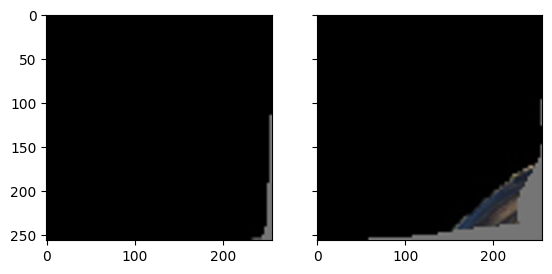

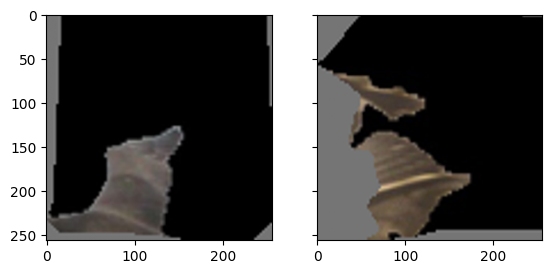

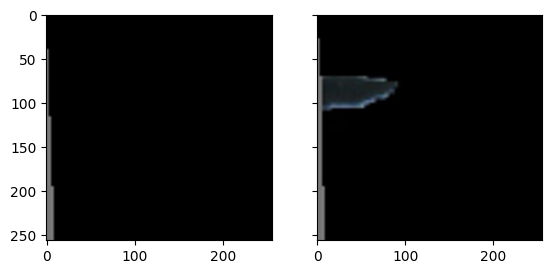

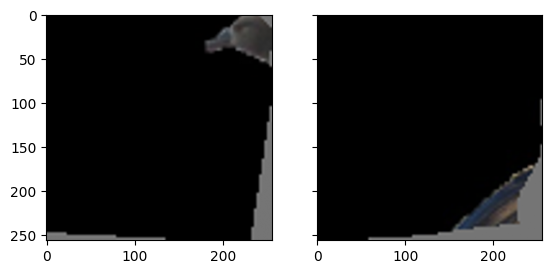

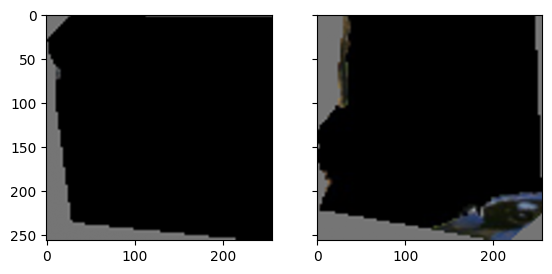

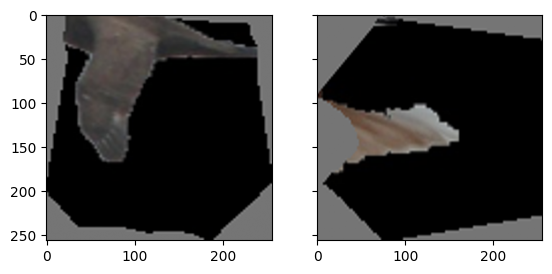

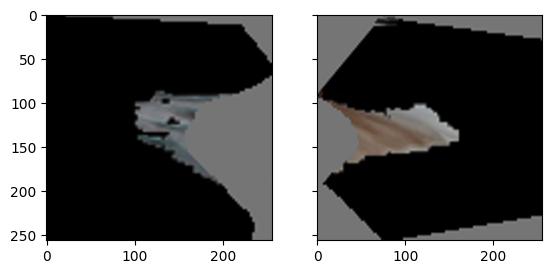

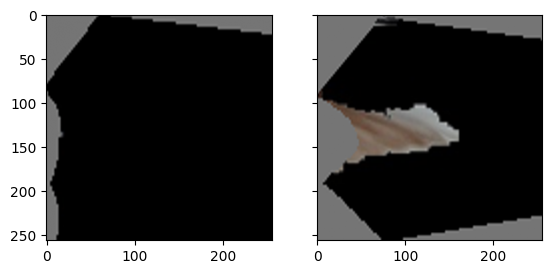

In [23]:
cluster_fileName = '/content/drive/MyDrive/Colab Notebooks/Clustering/K-Means/concepts_clusters_08_07_2023.h5'

with h5py.File(cluster_fileName, 'r') as f:
  concept_imgs = f['concept_img'][()]
  concept_embdd = f['concept_embedding'][()]

from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# fileName = '/content/Dataset/orginal_images_cache/8/Rose_Breasted_Grosbeak_0042_39158.hdf5'
# fileName = '/content/Dataset/orginal_images_cache/5/Vermilion_Flycatcher_0006_42564.hdf5'
# fileName = '/content/Dataset/orginal_images_cache/11/Rufous_Hummingbird_0009_59405.hdf5'
# fileName = '/content/Dataset/orginal_images_cache/4/Northern_Flicker_0051_28650.hdf5'
# fileName = '/content/Dataset/orginal_images_cache/2/Painted_Bunting_0010_16948.hdf5'
# fileName = '/content/Dataset/orginal_images_cache/14/Brown_Pelican_0012_94079.hdf5'
# fileName = '/content/Dataset/orginal_images_cache/7/European_Goldfinch_0005_33263.hdf5'
fileName = '/content/Dataset/orginal_images_cache/0/Black_Footed_Albatross_0010_796097.hdf5'

with h5py.File(fileName, 'r') as f:
  sp = f['superpixels'][()]#f['superpixels'].value
  norm_feat = f['norm_feat'][()]#f['norm_feat'].value

  dis_matrix = cdist(norm_feat, concept_embdd)
  print(dis_matrix.shape)
  pred_cluster_centers = np.argmin(dis_matrix, axis=1)
  # print(pred_center)
  # predicted_concepts = concepts_names_clusterwise[pred_center]
  # print(predicted_concepts[0])

  for ind in range(len(sp)):
    fig, ax = plt.subplots(1, 2, sharex='col', sharey='row')
    # print(sp[ind].shape)
    # print(concept_img.shape)

    ax[0].imshow(sp[ind])
    pred_center = pred_cluster_centers[ind]
    predicted_concept_img = concept_imgs[pred_center]
    ax[1].imshow(predicted_concept_img)
    plt.show()


In [ ]:
!ls

 15_classes_embeddings_02_03_2022.tar
 ahsan_notebook_Clustering.ipynb
 Classwise_15_Concepts_150_VGG_02_03_2022
 clustering_Data_02_03_2022.csv
'Clustering for new model.ipynb'
 concepts_clusters_02_03_2022.csv
 concepts_clusters.h5
 concepts_clusterwise_02_03_2022
 CUB_200_masked.zip
 cubResNet.ipynb
 kmeans_15_classes_150_clusters_VGG.pkl
 ResNet50.ipynb
 selective_data_15classes.zip


## **Matching Input Image with all Clusters**

(8, 150)
78


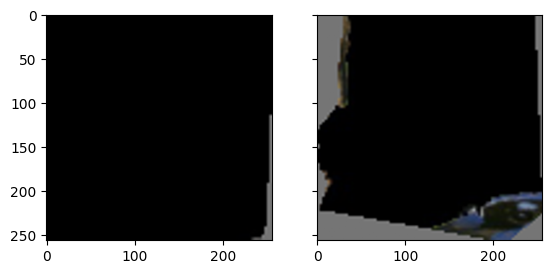

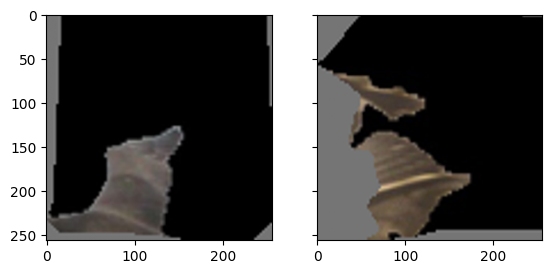

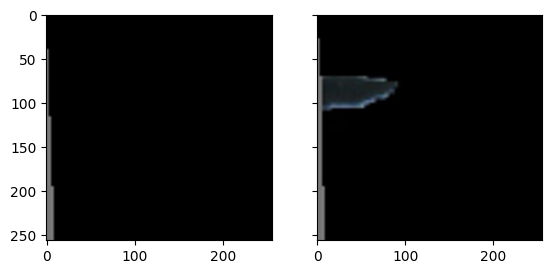

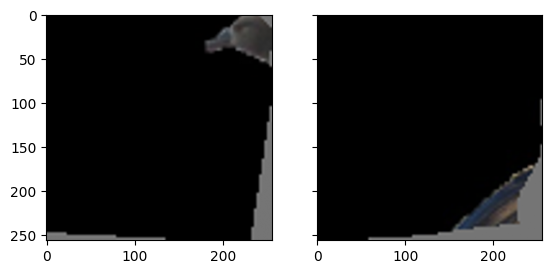

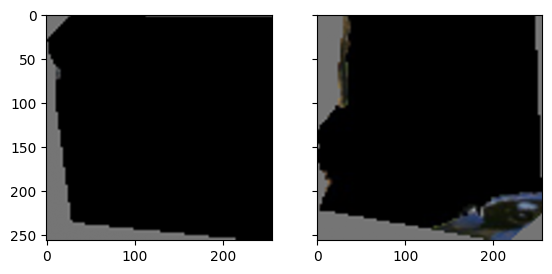

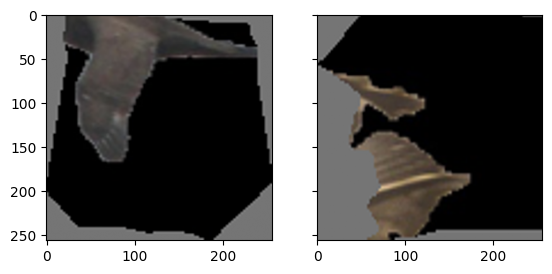

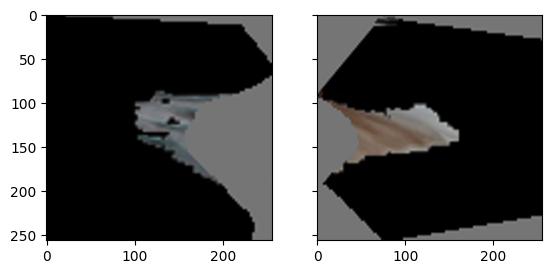

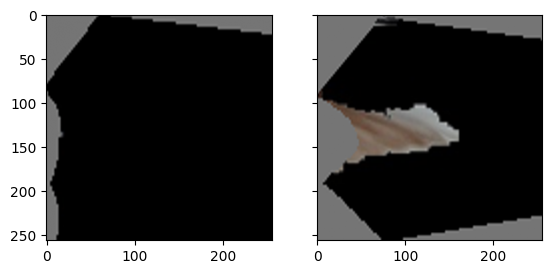

In [24]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# fileName = '/content/Dataset/orginal_images_cache/3/Eastern_Towhee_0001_22314.hdf5'
# fileName = '/content/Dataset/orginal_images_cache/5/Vermilion_Flycatcher_0006_42564.hdf5'
# fileName = '/content/Dataset/orginal_images_cache/11/Rufous_Hummingbird_0009_59405.hdf5'
# fileName = '/content/Dataset/orginal_images_cache/4/Northern_Flicker_0051_28650.hdf5'
# fileName = '/content/Dataset/orginal_images_cache/2/Painted_Bunting_0010_16948.hdf5'
# fileName = '/content/Dataset/orginal_images_cache/14/Brown_Pelican_0012_94079.hdf5'
# fileName = '/content/Dataset/orginal_images_cache/7/European_Goldfinch_0005_33263.hdf5'
fileName = '/content/Dataset/orginal_images_cache/0/Black_Footed_Albatross_0010_796097.hdf5'

with h5py.File(fileName, 'r') as f:
  sp = f['superpixels'][()]#f['superpixels'].value
  norm_feat = f['norm_feat'][()]#f['norm_feat'].value
  # for embedding,img_sp in zip(norm_feat,sp):
  #   plt.imshow(img_sp)
  #   plt.show()
  # sp_mean = np.sum(sp,axis=1)
  # print(sp_mean)
  # print(sp_mean.shape)

  dis_matrix = cdist(norm_feat, centers)
  print(dis_matrix.shape)
  pred_cluster_centers = np.argmin(dis_matrix, axis=1)
  print(pred_center)
  # predicted_concepts = concepts_names_clusterwise[pred_center]
  # print(predicted_concepts[0])

  for ind in range(len(sp)):
    fig, ax = plt.subplots(1, 2, sharex='col', sharey='row')
    # print(sp[ind].shape)
    # print(concept_img.shape)

    ax[0].imshow(sp[ind])
    pred_center = pred_cluster_centers[ind]
    predicted_concepts = concepts_names_clusterwise[pred_center]
    concept_img = plt.imread(predicted_concepts)
    ax[1].imshow(concept_img)
    plt.show()


In [ ]:
# dis_matrix = cdist(norm_feat, centers)
# print(dis_matrix.shape)
# a = [[2, 2, 3,5,-10],[5,1, 0, 3, 1]]
# print(a)
# np.argmin(a, axis=0)

## **Matching Concepts with cluster centers**

(10, 150)
[125  56 107 119  21  86   3 115  75  84]


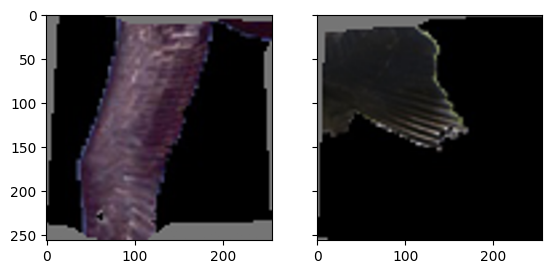

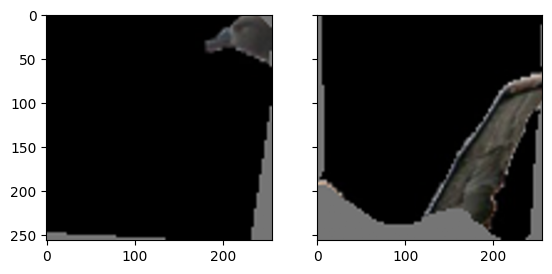

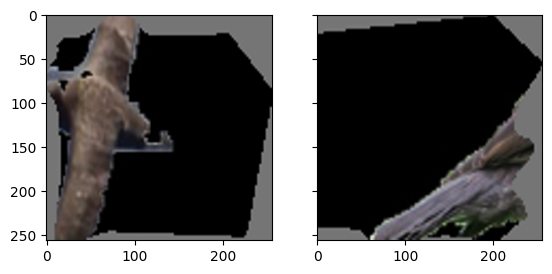

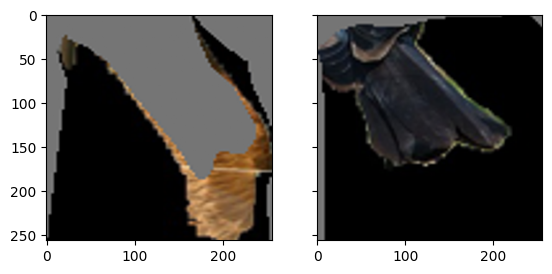

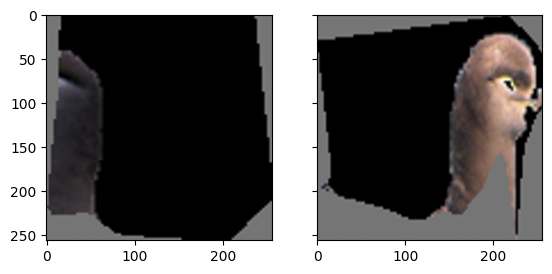

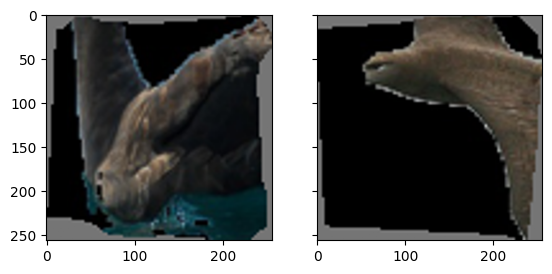

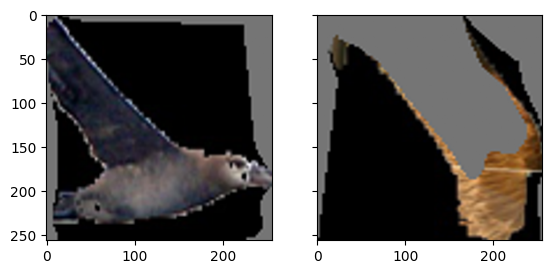

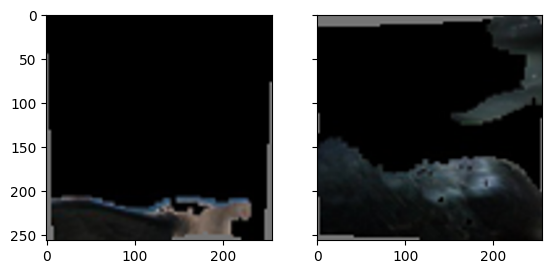

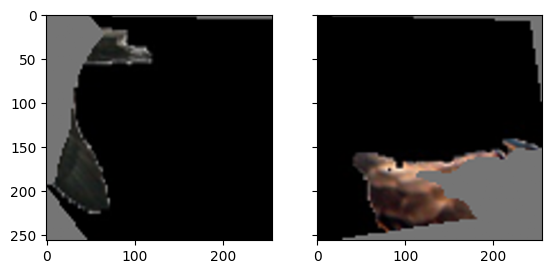

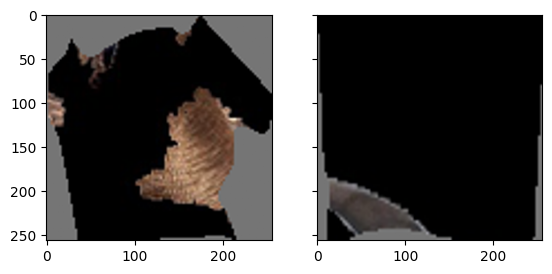

In [25]:
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt

# concept_embeddings = []
# concept_embeddings_name = []
# concept_image_name = []
# concept_label = []


sp = concept_image_name[0:10]
norm_feat = concept_embeddings[0:10]

dis_matrix = cdist(norm_feat, centers)
print(dis_matrix.shape)
pred_center = np.argmin(dis_matrix, axis=1)
print(pred_center)

predicted_concepts = concept_image_name[pred_center]
# print(predicted_concepts[0])
for ind in range(len(sp)):
  fig, ax = plt.subplots(1, 2, sharex='col', sharey='row')
  # print(sp[ind].shape)
  # print(concept_img.shape)
  sp_img = plt.imread(sp[ind])
  ax[0].imshow(sp_img)
  concept_img = plt.imread(predicted_concepts[ind])
  ax[1].imshow(concept_img)
  plt.show()

# **Clustering using KNN**

## **Reading Embeddings**

In [ ]:
concept_embeddings_name_knn = []
concept_embeddings_knn = []
concept_image_name_knn = []
concept_label_knn = []

knn_dataList = []

dirs = sorted(os.listdir(concept_dir_cache))
for subDir in dirs:
  subDirPath = os.path.join(concept_dir_cache,subDir)
  files = sorted(os.listdir(subDirPath))
  for file in files:
    filename, file_extension = os.path.splitext(file)

    filePath = os.path.join(subDirPath,file)
    concept_embeddings_name_knn.append(filePath)
    concept_label_knn.append(subDir)
    concept_image = os.path.join(concept_dir,subDir,filename+'.png')
    concept_image_name_knn.append(concept_image)

    # print(filePath)
    with h5py.File(filePath, 'r') as f:
      norm_feat = f['norm_feat'][()]   #key changed from embedding to norm_feat
      norm_feat = np.squeeze(norm_feat)
      concept_embeddings_knn.append(norm_feat)
  mytuple = (concept_embeddings_name_knn,concept_image_name_knn,concept_label_knn)
  knn_dataList.append(mytuple)

concept_embeddings_name_knn = np.array(concept_embeddings_name_knn)
concept_embeddings_knn = np.array(concept_embeddings_knn)
concept_image_name_knn = np.array(concept_image_name_knn)
concept_label_knn = np.array(concept_label_knn)

In [ ]:
print(concept_embeddings_name_knn[0])

/content/Dataset/filtered_concepts_embeddings/0/10_332.hdf5
/content/Dataset/concepts/0/10_332.png
0


In [ ]:
# def fileCounter(folder):
#   count = 0
#   dirs = os.listdir(folder)
#   for subDir in dirs:
#     subDirPath = os.path.join(folder,subDir)
#     files = os.listdir(subDirPath)
#     for file in files:
#       filePath = os.path.join(subDirPath,file)
#       if os.path.isfile(filePath):
#         count += 1
#   return count

In [ ]:
# print(fileCounter('/content/Dataset/filtered_concepts_embeddings'))

1171


In [ ]:
# concept_embeddings_array = np.squeeze(np.array(dataframe.iloc[:,2]))
concept_embeddings_knn = np.squeeze(np.array(concept_embeddings_knn))
print(concept_embeddings_knn.shape)

(1171, 512)
(1171, 512)


In [ ]:
# for embedding in concept_embeddings_array:
#   print(embedding)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbor = 5
print('\nStart KNN-Clustring')
clf = KNeighborsClassifier(n_neighbors=n_neighbor, n_jobs=1)
clf.fit(concept_embeddings_knn, concept_label_knn)
Y_pred = clf.predict(concept_embeddings_knn)
print('End Fitting')
kneighbors = clf.kneighbors
# print(Y_pred)
# print(concept_label_knn)
pred_prob = clf.predict_proba(concept_embeddings_knn[0:1])
print(pred_prob)


Start KNN-Clustring
End Fitting
[[0.8 0.  0.  0.  0.  0.  0.2 0.  0.  0.  0.  0.  0.  0.  0. ]]


In [ ]:
concept_embeddings_name_knn[0]

In [ ]:
print(kneighbors[0])

TypeError: ignored